# Vehicle detection and tracking using deep learning

> * 🔬 Data Science
* 🥠 Deep Learning and Object Detection
* 🛤️ Tracking

## Table of Contents
* [Introduction and objective](#Introduction-and-objective)
* [Necessary imports](#Necessary-imports)
* [Prepare data that will be used for training](#Prepare-data-that-will-be-used-for-training)
* [Model training](#Model-training)
 * [Visualize training data](#Visualize-training-data)
 * [Load model architecture](#Load-model-architecture)
 * [Train the model](#Train-the-model)
 * [Visualize results on validation set](#Visualize-results-on-validation-set)
 * [Save the model](#Save-the-model) 
* [Inference and tracking](#Inference-and-tracking)
* [Conclusion](#Conclusion)

## Introduction and objective

Vehicle detection and tracking is a common problem with multiple use cases.
Government authorities and private establishment might want to understand the traffic flowing through a place to better develop its infrastructure for the ease and convenience of everyone. A road widening project, timing the traffic signals and construction of parking spaces are a few examples where analysing the traffic is integral to the project.

Traditionally, identification and tracking has been carried out manually. A person will stand at a point and note the count of the vehicles and their types. Recently, sensors have been put into use, but they only solve the counting problem. Sensors will not be able to detect the type of vehicle.

In this notebook, we'll demonstrate how we can use deep learning to detect vehicles and then track them in a video. We'll use a short [video](https://youtu.be/e8cxjNE-4_I) taken from live traffic camera feed.

## Necessary imports

In [1]:
import pandas as pd

from arcgis.learn import RetinaNet, prepare_data

## Prepare data that will be used for training

You can download vehicle training data from [here](https://github.com/Esri/arcgis-python-api/tree/master/samples/04_gis_analysts_data_scientists/data/vehicle_training_data.zip). Extract the downloaded file to get your training data.

## Model training

Let's set a path to the folder that contains training images and their corresponding labels.

In [ ]:
data_path = "data/vehicle_detection"

We'll use the `prepare_data` function to create a fastai databunch with the necessary parameters such as `batch_size`, and `chip_size`. A complete list of parameters can be found in the [API reference](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.learn.html#prepare-data).

The given dataset has 235 images of size 854x480 pixels. We will define a `chip_size` of 480 pixels which will create random crops of 480x480 from the given images. This way we will maintain the aspect ratios of the objects but can miss out on objects when training the model for fewer epochs. To avoid cropping, we can set `resize_to`=480 so that every chip is an entire frame and doesn't miss any object, but there is a risk of poor detection with smaller sized object.

In [3]:
data = prepare_data(data_path, 
                    batch_size=4, 
                    dataset_type="PASCAL_VOC_rectangles", 
                    chip_size=480)

Please check your dataset. 9 images dont have the corresponding label files.


We see the warning above because there are a few images in our dataset with missing corresponding label files. These images will be ignored while loading the data. If it is a significant number, we might want to fix this issue by adding the label files for those images or removing those images.

We can use the `classes` attribute of the data object to get information about the number of classes.

In [4]:
data.classes

['background',
 'bicycle',
 'bus',
 'car',
 'motorcycle',
 'person',
 'scooter',
 'tempo',
 'tractor',
 'truck',
 'van']

### Visualize training data

To visualize and get a sense of the training data, we can use the `data.show_batch` method.

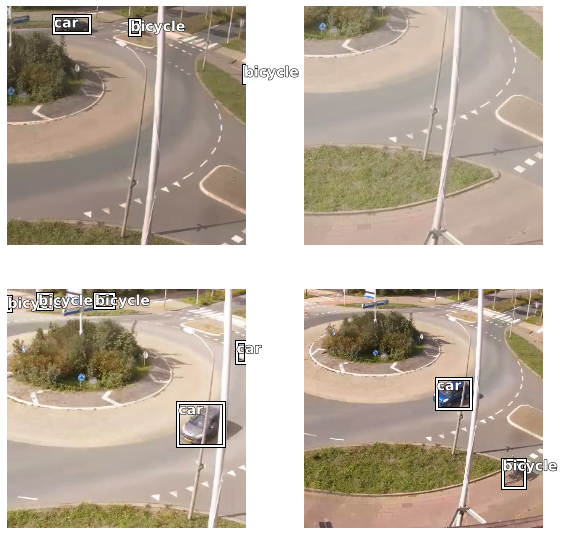

In [14]:
data.show_batch()

In the previous cell, we see a sample of the dataset. We can observe, in the given chips, that the most common vehicles are cars and bicycles. It can also be noticed that the different instance of the vehicles have varying scales.

### Load model architecture

`arcgis.learn` provides us object detection models which are based on pretrained convnets, such as ResNet, that act as the backbones. We will use `RetinaNet` with the default parameters to create our vehicle detection model. For more details on `RetinaNet` check out [How RetinaNet works?]() and the [API reference](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.learn.html#retinanet).

In [6]:
retinanet = RetinaNet(data)

We will use the `lr_find()` method to find an optimum learning rate. It is important to set a learning rate at which we can train a model with good accuracy and speed.

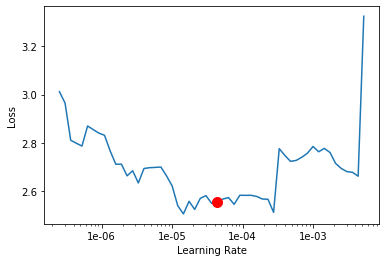

4.365158322401661e-05

In [7]:
retinanet.lr_find()

### Train the model

We will now train the `RetinaNet` model using the suggested learning rate from the previous step. We can specify how many epochs we want to train for. Let's train the model for 100 epochs. Also, we can turn `tensorboard` True if we want to visualize the training process in tensorboard.

In [8]:
retinanet.fit(100, lr=4.365158322401661e-05, tensorboard=True) 

epoch,train_loss,valid_loss,time
0,2.651160,3.122699,00:33
1,2.727485,3.089710,00:32
2,2.744920,3.015922,00:32
3,2.671797,2.851994,00:31
4,2.457554,2.497410,00:31
5,2.381740,2.328834,00:31
6,2.060174,4.138567,00:31
7,1.792403,21.451857,00:31
8,1.712977,4.193508,00:31
9,1.608706,4.876813,00:32


After the training is complete, we can view the plot with training and validation losses.

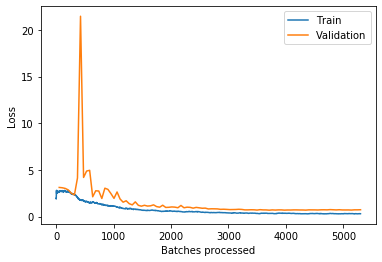

In [21]:
retinanet.learn.recorder.plot_losses()

### Visualize results on validation set

To see sample results we can use the `show_results` method. This method displays the chips from the validation dataset with ground truth (left) and predictions (right). We can also specify the threshold to view predictions at different confidence levels. This visual analysis helps in assessing the qualitative results of the trained model.

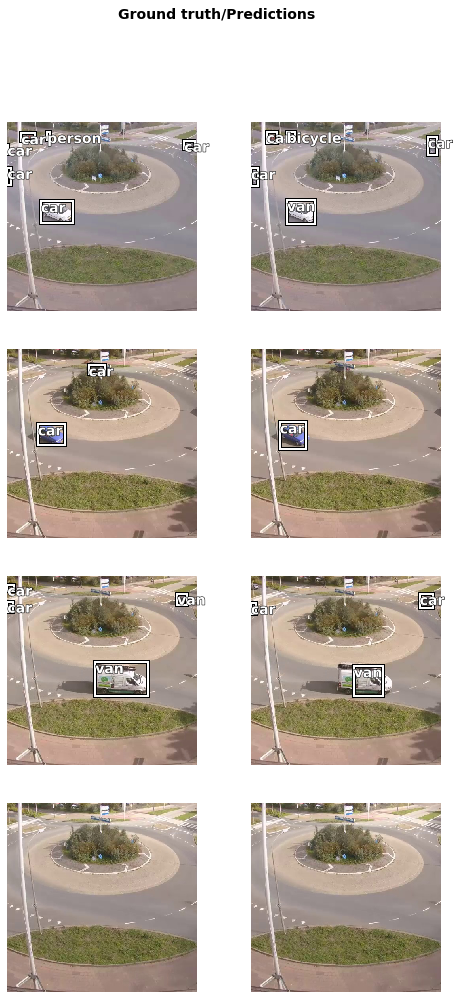

In [18]:
retinanet.show_results(thresh=0.4)

To see the quantitative results of our model we will use the `average_precision_score` method.

In [19]:
retinanet.average_precision_score(detect_thresh=0.4)

{'bicycle': 0.6121794875615674,
 'bus': 0.0,
 'car': 0.770548729309354,
 'motorcycle': 0.0,
 'person': 0.0,
 'scooter': 0.0,
 'tempo': 0.0,
 'tractor': 0.0,
 'truck': 1.0,
 'van': 0.38429487869143486}

We can see the average precision for each class in the validation dataset. Note that while car and bicycle have a good score, van doesn't, and a few have a score of 0. Remember when we visualized the data using `show_batch` we noted that the cars and bicycles were the most common objects. It means, the scores could be correlated with the number of examples of these objects we have in our training dataset.

Let's look at the number of instances of each class in the training data and it should explain.

In [22]:
all_classes = []
for i, bb in enumerate(data.train_ds.y):
    all_classes += bb.data[1].tolist()
    
df = pd.value_counts(all_classes, sort=False)
df.index = [data.classes[i] for i in df.index] 
df

bicycle       266
bus            19
car           756
motorcycle     33
person         24
scooter         6
tempo           1
tractor         4
truck          30
van            69
dtype: int64

It is evident that the classes that have a score of 0.0 have extremely low number of examples in the training dataset.

### Save the model

Let's save the model by giving it a name and calling the `save` method, so that we can `load` it later whenever required. The model is saved by default in a directory called `models` in the `data_path` initialized earlier, but a custom path can be provided.

In [11]:
retinanet.save('vehicle_det_ep100_defaults')

WindowsPath('vehicle_detection/models/vehicle_det_ep100_defaults')

## Inference and tracking


Multiple-object tracking can be performed using `predict_video` function of the `arcgis.learn` module. To enable tracking, set the `track` parameter in the `predict_video` function as `track=True`.

The following options/parameters are available in the predict video function for the user to decide:-

* `vanish_frames`: The number of frames the object remains absent from the frame to be considered as vanished.

* `detect_frames`: The number of frames an object remains present in the frame to start tracking.

* `assignment_iou_thrd`: There might be multiple trackers detecting and tracking objects. The Intersection over Union (iou) threshold can be set to assign a tracker with the mentioned threshold value.


In [ ]:
retinanet.predict_video(input_video_path=r'data/test.mp4', 
                        metadata_file=r'data/vid1.csv',
                        track=True, 
                        visualize=True, 
                        threshold=0.5,
                        resize=True)

<video width="100%" height="450" loop="loop" controls src="../../static/video/test_predictions.mp4" />

We can count the number of vehicles per unit of time and update a feature layer with the live count of cars, buses, trucks etc. When this process is done for multiple intersections within the city, an ArcGIS dashboard can be created. It queries the continually updated feature layers and displays the results using a dashboard such the following:

<video width="100%" height="450" loop="loop" controls src="../../static/video/video_dc_parade.mp4" />

## Conclusion

In this notebook, we have learnt how to automate multi-object tracking and counting system. This will not only help in  intelligent traffic management but can be found useful in wide variety of applications.